### __Environment set up__

In [ ]:
# Importing dependencies

import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")  # You may need to do this if don't have the nltk corpora (singlular: corpus) already downloaded in your environment
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # now needed to load wordnet on linux, i guess- as I am using google collab- and collab runs on linux
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import  WordNetLemmatizer
#from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
#from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
articles_df = pd.read_csv("/content/news_articles.csv")

Examining the data

In [ ]:
articles_df.shape

(3122, 5)

In [ ]:
articles_df.head()

,contentId,eventType,title,text,lang
0,-6.451310e+18,CONTENT REMOVED,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-4.110354e+18,CONTENT SHARED,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,-7.292285e+18,CONTENT SHARED,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,-6.151852e+18,CONTENT SHARED,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,2.448027e+18,CONTENT SHARED,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


Notice, from the `eventtype` column, that some of the content have been removed. Will have to drop such rows. Only content still available can be recommended.

In [ ]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   contentId  3122 non-null   float64
 1   eventType  3122 non-null   object 
 2   title      3122 non-null   object 
 3   text       3118 non-null   object 
 4   lang       3122 non-null   object 
dtypes: float64(1), object(4)
memory usage: 122.1+ KB


There are missing values in the `text` column.

### __Preprocessing the data__

Let's begin with checking for duplicate records, addressing missing values and dropping columns not relevant to building the recommender system.

In [ ]:
# FIrst, filtering out rows with 'removed content' and excluding columns irrelevant to building the recommender system.

shared_articles = articles_df.loc[articles_df.eventType == "CONTENT SHARED", ["title", "text", "lang"]]

In [ ]:
shared_articles.head()

,title,text,lang
1,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [ ]:
shared_articles.shape

(3047, 3)

In [ ]:
# Checking for duplicate records

shared_articles.duplicated().sum()

30

In [ ]:
# Dropping duplicate records

shared_articles.drop_duplicates(inplace = True)

# confirming that duplicate records were dropped

shared_articles.shape

(3017, 3)

In [ ]:
# Addressing missing values. 
# We already got some hint about the presence of some missing values in the `text` column earlier. Let's confirm.

shared_articles.isna().sum()

title    0
text     4
lang     0
dtype: int64

In [ ]:
# There are missing values in the `text` column. This column is the most important in the project so, the text in some rows cannot be missing. Dropping these rows.

shared_articles.dropna(inplace = True)

In [ ]:
# Confirming removal of rows with missing values in the `text` column.
shared_articles.shape

(3013, 3)

In [ ]:
# Checking what languages the content are written in. Are they all written in english or there are content in other languages?

shared_articles.lang.value_counts()

en    2182
pt     824
la       3
es       2
ja       2
Name: lang, dtype: int64

In [ ]:
# excluding rows of content not in english.

articles_eng = shared_articles[shared_articles.lang == "en"].reset_index(drop = True)

In [ ]:
articles_eng.head()

,title,text,lang
0,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Now, I'll combine the `title`, `text` and `language` columns into one. The engine we want to build is a recommender system, so every textual data relating to a content- including those in the title- and the context around it, can play a role in pointing to which set of other content are related to it. I'll drop the drop the individual `title` and `lang` columns after the combination.

In [ ]:
# Combining the three columns: `title`, `text`, `lang`

articles_eng["text"] = articles_eng.title + " " + articles_eng.text + articles_eng.lang

articles_eng.drop(["title", "lang"], axis = 1, inplace = True)

In [ ]:
articles_eng.head()

,text
0,"Ethereum, a Virtual Currency, Enables Transact..."
1,Bitcoin Future: When GBPcoin of Branson Wins O...
2,Google Data Center 360° Tour We're excited to ...
3,"IBM Wants to ""Evolve the Internet"" With Blockc..."
4,IEEE to Talk Blockchain at Cloud Computing Oxf...


Next prepocessing steps
* Remove punctuation
* Standardize - in this case, conversion to lowercase
* Tokenize
* Remove stopwords
* Stem

We can achieve all these steps with a function.

In [ ]:
eng_stopwords = stopwords.words("english")
lem = WordNetLemmatizer()

In [ ]:
# Making a copy of the dataframe before applying these steps

articles_eng2 = articles_eng.copy()

In [ ]:
# text cleaning function

def cleantext(text):
    text = re.sub("[^A-Za-z0-9 ]", "", text)           
    text = text.lower()                                 
    tokens = word_tokenize(text)                        
    cleaned_txt = []                                    
    for token in tokens:                                
        if token not in eng_stopwords:                  # removing stopwords because, typically, a recommender system will consider related keywords to recommend
            cleaned_txt.append(lem.lemmatize(token))   
    return " ".join(cleaned_txt)

In [ ]:
articles_eng2["text"] = articles_eng2.text.apply(cleantext)

In [ ]:
articles_eng2.head()

,text
0,ethereum virtual currency enables transaction ...
1,bitcoin future gbpcoin branson win usdcoin tru...
2,google data center 360 tour excited share goog...
3,ibm want evolve internet blockchain technology...
4,ieee talk blockchain cloud computing oxfordcon...


__Feature encoding__


In this case, vectorization- Converting the text data to numeric

The result is usually a sparse matrix. Most of the values in it are zeros so, in the matrix, only the location of none-zero values are stored. This is to save space. But when the matrix is converted to an array (ndarray), the zeros can be seen.

In [ ]:
encoder = TfidfVectorizer()

In [ ]:
vectorized_text = encoder.fit_transform(articles_eng2.text).toarray()

vectorized_text_kn = vectorized_text.copy()

In [ ]:
print(type(vectorized_text_kn))

<class 'numpy.ndarray'>


### __Building the Model__

__Using KMeans__

__Getting Optimal Number of Clusters__

FIrst, let's determine the optimal number of clusters. The number of clusters in this case would mean number of groups of articles- based on close relation- in the dataset

I'll use the elbow method to determine the optimal number of clusters I should use to build my model.

This can be achieved with a loop or, the built-in KElbowVisualizer from from the yellowbrick.cluster module. Both are implemented below.

The elbow method may not always give the most accurate k, especially when the data does not show clear enough demarcation or clustering, maybe due to a lot of noise. The result is only a figure it considers would be optimal for the model. I prefer the KElbowVisualizer because it produces a visual that gives an idea where the elbow is through a straight line at the optimal k, especially for unclear data for which this is difficult to interpret manaually. 

Optimal k is the point after which, the sum of squared distances stops dropping significantly.



In [ ]:
# Finding optimal k manually

ss_distance = [] #sum of squared distances
k_range = range(2, 31)  # I want the number of clusters to be tested begin from 2 and stop at 20
for c in k_range:
  km_model = KMeans(n_clusters=c)    # the elbow method uses K means, just that it does not specify the number of clusters, k
  km_model.fit(vectorized_text_kn)
  ss_distance.append(km_model.inertia_)
ss_distance

[2092.7017817709298,
 2080.8102741450375,
 2070.9111567765003,
 2056.217133913262,
 2045.5523625382114,
 2034.9115023380446,
 2026.394418768783,
 2018.247268208965,
 2007.2426652214367,
 2004.0677374027305,
 2000.967938268774,
 1991.4611080931327,
 1988.6718259026152,
 1984.6270801474989,
 1980.2223629075484,
 1976.6743582284075,
 1969.093386534753,
 1967.716540253967,
 1962.7283055608582,
 1960.0981314034548,
 1956.2317002501486,
 1952.40042441848,
 1951.0108166984896,
 1947.8333318345826,
 1943.606634110617,
 1941.0016904819825,
 1936.9763981725673,
 1936.7815908327036,
 1932.964109927954]

Text(0, 0.5, 'Inertia')

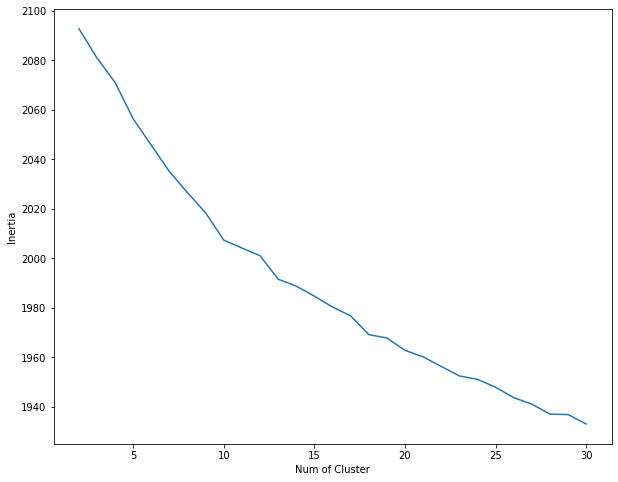

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
plt.plot(k_range, ss_distance)
plt.xlabel("Num of Cluster")
plt.ylabel("Inertia")

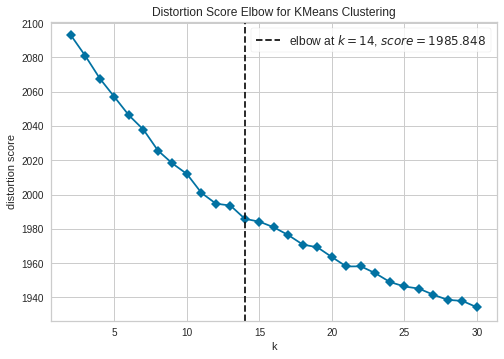

In [ ]:
# Using the built-in KElbowVisualizer to find optimal k.

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KElbowVisualizer(KMeans(), k=30, timings = False)
model.fit(vectorized_text_kn)
model.show()

The KElbowVisualizer is proposing a k of 14 so, i'll use this to build the model. 

PS: It appears the optimal number of clusters, k seem to change as I change the range of k to test. I noticed that when the range was from 2 to 20, the optimal k was 12 but when I extented it to 30, the optimal k was 17. I ran the same cell again, using the same range, and I got another optimal k at 14..
Now, let's train the model.

In [ ]:
# first, configuring the model. I am doing another configuration because the first was used in finding the optimal k.

model = KMeans(n_clusters= 14, random_state= 42)

# Training the model

model.fit(vectorized_text_kn)

KMeans(n_clusters=14, random_state=42)

Although I have used a clustering algorithm to build this first model, what we primarily need is a system that recommends related articles based on an article a user is currently reading. 

So, even without supplying new data, we can try to see which class an article in the train data falls into and what are the other articles that have the same class labels as it. These other articles will be the articles most related to that particular article, according to the model we have trained. 

Essentially, we may not need to apply the .predict() method now unless we want to find what cluster a new, unseen article belongs to. Based on the business problem at hand, what we want to achieve primarily, is to recommend articles related to a focus article. 

We can do this by getting the class of the article we are trying to find related articles for and we subset the dataframe for other articles in that class. 
Those will be our recommended articles.

In [ ]:
# First, getting the new labels and merging this to the news_articles dataframe as a new column. 
# We are able to do this because the order pf predictions matches the order in the original input data. 
# So, each row of prediction has a corresponding row in the input data. 
# The order is usually preserved when computing predictions from ml models

group = model.labels_

# adding the new labels to the initial dataframe as a new column

articles_eng["group"] = group

In [ ]:
articles_eng.head()

,text,group
0,"Ethereum, a Virtual Currency, Enables Transact...",13
1,Bitcoin Future: When GBPcoin of Branson Wins O...,10
2,Google Data Center 360° Tour We're excited to ...,12
3,"IBM Wants to ""Evolve the Internet"" With Blockc...",13
4,IEEE to Talk Blockchain at Cloud Computing Oxf...,13


In [ ]:
# Let's check how many articles fall into each class

articles_eng.group.value_counts()

10    698
7     387
5     224
9     201
3     109
12     99
13     96
2      68
6      55
11     52
4      52
1      49
8      46
0      46
Name: group, dtype: int64

In [ ]:
# Now, I'll get one of the articles in the original dataset, get its group and output the first 10 articles in that group to inspect what kind of content they contain and how they are related.

test_article = articles_eng.iloc[305, :]

# Let's get the group it belongs to

print(f"This article belongs to group {test_article.group}")
print(test_article.text)

This article belongs to group 7
NoSQL Performance Benchmarks Benchmarking NoSQL Databases: Cassandra vs. MongoDB vs. HBase vs. Couchbase Understanding the performance behavior of a NoSQL database like Apache Cassandra ™ under various conditions is critical. Conducting a formal proof of concept (POC) in the environment in which the database will run is the best way to evaluate platforms. POC processes that include the right benchmarks such as production configurations, parameters and anticipated data and concurrent user workloads give both IT and business stakeholders powerful insight about platforms under consideration and a view for how business applications will perform in production. Independent benchmark analyses and testing of various NoSQL platforms under big data, production-level workloads have been performed over the years and have consistently identified Apache Cassandra as the platform of choice for businesses interested in adopting NoSQL as the database for modern Web, mobi

In [ ]:
# Get articles in the same group as the test_article

articles_eng.text[articles_eng.group == 7][370:-1]

2123    Spring Boot 1.5.1 released One behalf of the S...
2125    IBM Seeks to Simplify Graph with New Titan Ser...
2128    GitLab.com melts down after backup fail and da...
2131    Building Event-driven Microservices Using CQRS...
2138    Speed Up a WordPress Website in 8 Steps Althou...
2139    The Complete Google Analytics Audit Checklist ...
2147    Python - It's metaclasses all the way down Met...
2155    Now sites can fingerprint you online even when...
2158    Don't document your code. Code your documentat...
2159    What do you mean by "Event-Driven"? Towards th...
2164    When to make a Git Commit You don't have to lo...
2167    How to build cross-platform mobile apps using ...
2168    Amazon EBS Update - New Elastic Volumes Change...
2170    Concrete things you can do about your technica...
2171    Optimizing the Performance of Vector Drawables...
2174    Another option for file sharing Existing mecha...
Name: text, dtype: object

Most of the articles in group 7 appear to be about core tech generally, coding and building digital products.

__Let's check the performance of the model.__

Since there were no labels at all for this data prior to the training, I will use the sihlouette coefficient  and the variance_ratio coefficient.

The Silhoutte score reveals the closeness of each point to the cluster it is grouped into, compared to how close it is to other clusters.

Variance Ratio Criterion speaks to the distance, on average, from each point to the center of the cluster it belongs to and cluster-to-cluster distance.

In [ ]:
# Using silhoutte score.

metrics.silhouette_score(vectorized_text_kn, group, metric = 'euclidean')

0.014362190468073917

According to Sklearn's silhoutte score documentation, 
"The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar"

Going by this information, the model is not performing well enough. With the silhoutte score so close to zero, overlapping clusters are very likely. This is not surpising though. The data is textual. It is not unlikely that a particular keyword could have appeared, even if just once, in other articles belonging to one or more other clusters.

In [ ]:
# Using the variace-ratio criterion

metrics.calinski_harabasz_score(vectorized_text_kn, group)

9.92506031854669

For the variance-ratio criterion, there is no fixed cut-off but when the value is higher, it is an indication that the clusters are clear off each other and well separated. This value is low.

One shortcoming I perceive with the model is the class Inbalance in the grouping. There's need to investigate if this is due to articles in the class with the highest number of related articles being, indeed, related and just happen to be the kind of articles that is mostly found on this news website, or that this is a case of misclustering. 

Also I noticed that, even though I set random state for training the model, the group of each article changes each time I re-run the cell that has the code for fitting the model.

__Using Cosine Similarity__

Here, In place of the kmeans clustering model, I am proceeding straightaway from vectorization to using
cosine similarity as a metric to compute the similarity between two articles by taking the cosine of the angle between two vectors representing these articles.

A cosine similarity of zero means 'no similarity' while 1 means that the two articles are either perfectly similar or, the exact same articles. The result ranges between 0 and 1.


In [ ]:
# FIrst, making a copy of `vectorized_text`

vectorized_text_cs = vectorized_text.copy()

In [ ]:
# Getting the cosine_similarities, usually outputed as a matrix.

cos_similarity= cosine_similarity(vectorized_text_cs)

In [ ]:
# Looking at it as a dataframe

pd.DataFrame(cos_similarity).head()

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,1.000000,0.046464,0.019135,0.238359,0.096303,0.190434,0.169288,0.163548,0.851137,0.018125,...,0.049436,0.049856,0.027415,0.006715,0.025910,0.011027,0.021436,0.060298,0.104808,0.012673
1,0.046464,1.000000,0.018625,0.045762,0.023282,0.054362,0.040782,0.054849,0.038658,0.010776,...,0.034269,0.027863,0.006661,0.002326,0.013440,0.004549,0.017792,0.029071,0.040475,0.010874
2,0.019135,0.018625,1.000000,0.016380,0.036852,0.014113,0.020942,0.018663,0.016166,0.045948,...,0.054732,0.049333,0.017642,0.004562,0.027446,0.025623,0.071255,0.021021,0.036621,0.000000
3,0.238359,0.045762,0.016380,1.000000,0.196021,0.163726,0.237590,0.129486,0.177431,0.014561,...,0.075461,0.045801,0.026587,0.006807,0.048362,0.027848,0.016877,0.031642,0.104817,0.014585
4,0.096303,0.023282,0.036852,0.196021,1.000000,0.043669,0.140368,0.078341,0.060645,0.015087,...,0.056501,0.027072,0.011750,0.017063,0.012123,0.008258,0.019305,0.052254,0.075855,0.009561


The cosine similarity scores in the dataframe above show that articles being compared to each other in this subset of the data are barely similar. Most of the scores are closer to, than farther from zero(0).

In [ ]:
# To test, we'll get the index of an article from our initial `articles_eng` dataframe and collect the indices and scores of articles compared to it, in a list, using the cos_similarity matrix.
# Let's use the test_article we used in the KMeans model evaluation step so we can compare the results.

test_article_cs = test_article.text

# Defining a function that gets us the index of the test article.

def get_text_index(text):         # We are assuming we don't know the index yet
    return articles_eng[articles_eng.text == text].index.values[0]

article_index = get_text_index(test_article_cs)

print(article_index)

305


In [ ]:
# Now, lets get a list of all the similarity scores generated after comparing our test_article with all other articles.
# The result is a list of tuples containing the index of each article and the similarity score from comparing it with the test_article.

articles_index_score = list(enumerate(cos_similarity[article_index]))

print(articles_index_score)

[(0, 0.035974191823815754), (1, 0.0170319341443754), (2, 0.04390128807292025), (3, 0.024590447702921243), (4, 0.03820550305310715), (5, 0.01424198698193228), (6, 0.053452051438413556), (7, 0.01672600768165412), (8, 0.02958075549954719), (9, 0.043033102169932044), (10, 0.03926428163330043), (11, 0.0072207477769225415), (12, 0.02730643733689462), (13, 0.03190942906049919), (14, 0.02844841334903887), (15, 0.016102690688696783), (16, 0.03001978233144721), (17, 0.0644420214329645), (18, 0.020674365809649205), (19, 0.03556935180951523), (20, 0.014987853933567798), (21, 0.046928715538080465), (22, 0.02850608313695882), (23, 0.03636767527062045), (24, 0.009074206098329946), (25, 0.010265458224773434), (26, 0.017683529005352826), (27, 0.008537148255762086), (28, 0.01164741169922488), (29, 0.02294981198378461), (30, 0.025193280599462655), (31, 0.006848476278581468), (32, 0.023775033135347814), (33, 0.025872639664698167), (34, 0.03176221566276417), (35, 0.007736051871595808), (36, 0.0422468932356

In [ ]:
# We will now arrange the scores in descending order. This will bring the highest scores to the fore. 
# This way, we can examine the score to see if there are similarities at all and also output the articles that show similarity.
        
similar_articles_sorted = sorted(articles_index_score, key=lambda x:x[1], reverse=True)[:388]  # use the values specified by the lambda function (i.e., second element in each tuple) to order and give me the top 10.

similar_articles_sorted[:10]

[(305, 1.0),
 (1234, 0.4731011514622635),
 (1481, 0.3557574410731724),
 (2156, 0.26235023402101626),
 (350, 0.2056736766185862),
 (2031, 0.2045721415349984),
 (1233, 0.20006012669311796),
 (2117, 0.20004036919760682),
 (963, 0.19428241185014786),
 (1100, 0.1789302764449629)]

* The cosine similarities are, largely, low. Only one article recorded a score close to 0.5.

In [ ]:
# Now, Let's get the articles that correspond to these indices. Ofcourse, we see that the highest similarity score is from comparing the test article to itself.
# Let's define another function that will get the corresponding articles when we supply the indices we have obtained to it.

def get_index_text(index):
  return articles_eng[articles_eng.index == index].text.values[0]  # To acess the text themselves, as strings.

for i in similar_articles_sorted[:10]:
  print(get_index_text(i[0]))

NoSQL Performance Benchmarks Benchmarking NoSQL Databases: Cassandra vs. MongoDB vs. HBase vs. Couchbase Understanding the performance behavior of a NoSQL database like Apache Cassandra ™ under various conditions is critical. Conducting a formal proof of concept (POC) in the environment in which the database will run is the best way to evaluate platforms. POC processes that include the right benchmarks such as production configurations, parameters and anticipated data and concurrent user workloads give both IT and business stakeholders powerful insight about platforms under consideration and a view for how business applications will perform in production. Independent benchmark analyses and testing of various NoSQL platforms under big data, production-level workloads have been performed over the years and have consistently identified Apache Cassandra as the platform of choice for businesses interested in adopting NoSQL as the database for modern Web, mobile and IOT applications. One ben

In [ ]:
import numpy as np
ind_list = []
for i in similar_articles_sorted:
  if i[0] in (articles_eng.text[articles_eng.group == 7]):
    ind_list.append(i[0])

print(f" {len(ind_list)} indices are common in the results from both models")

 147 indices are common in the results from both models


This means that nearly 40% of the articles related to our test article according to the KMeans model, are also shown to be related to the test article, according to the cosine_similarity results. 

This comparison is not necessarily to use one of the models as a benchmark for the other. I just wanted to see if there was any uniformity in the results from these two different algorithms and this provides some credence.